# Krigeage 1D : simuler des nouvelles trajectoires

## Références

* Metamodeling with Gaussian processes, Bertrand Iooss, EDF R&D, 2014, www.gdr-mascotnum.fr/media/sssamo14_iooss.pdf
* https://github.com/openturns/www/blob/master/_images/scripts/plot_kriging.py
* http://trac.openturns.org/ticket/961
* http://trac.openturns.org/ticket/959
* http://trac.openturns.org/ticket/960

## Résumé

Dans ce segment, nous présentons comment créer un métamodèle de krigeage pour une fonction dont l'entrée et la sortie sont des variables réelles scalaires. Nous montrons comment créer la base d'apprentissage et la base de validation. Nous montrons comment créer le modèle de krigeage en choisissant une tendance et un modèle de covariance. Pour finir, nous montrons comment évaluer un intervalle de confiance du krigeage en exploitant la variance de krigeage. 

## Introduction

Dans cet exemple, nous considérons la fonction sinus :
$$
y = sin(x)
$$
pour $x\in[0,12]$. 

Nous souhaitons réaliser un métamodèle de cette fonction. Dans ce but, nous considérons un ensemble de $n$ observations de la fonction :
$$
y_i=sin(x_i)
$$
pour $i=1,...,7$, où $x_i$ est la i-ème abscisse et $y_i$ est l'ordonnée correspondante. 

Pour cela, nous considérons les 7 abscisses suivantes :

| $i$ | 1 | 2 | 3 | 4 | 5 | 6 | 7 |
|---|---|---|---|---|---|---|---|
| $x_i$ | 1 | 3 | 4 | 6 | 7.9 | 11 | 11.5 |

Nous allons considérer un métamodèle de krigeage associé à :
* une tendance constante,
* un noyau de covariance de Matern. 

## Création du métamodèle

Nous allons créer le méta-modèle avec OpenTURNS. Nous commençons par définir la fonction `g` comme une fonction symbolique. Puis nous définissons la variable `x_train` qui contient les abscisses du plan d'expériences, c'est à dire le plan d'expériences d'apprentissage. Puis, nous calculons les ordonnées `y_train` correspondantes. La variable `n_train` contient la taille de la base d'apprentissage.

In [1]:
import numpy as np
import openturns as ot

In [2]:
g = ot.SymbolicFunction(['x'], ['sin(x)'])

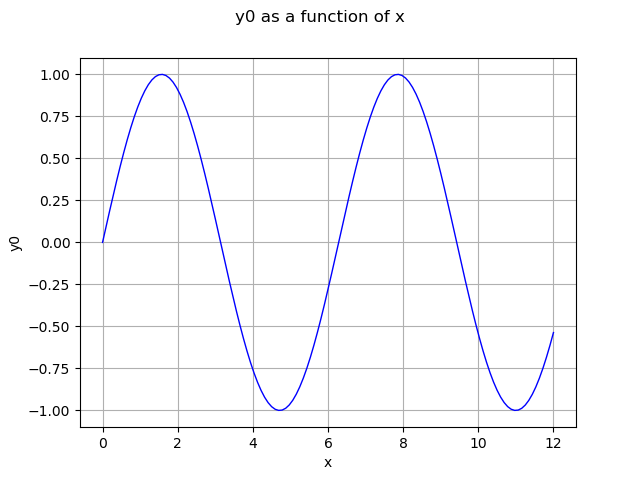

In [3]:
g.draw(0,12)

In [4]:
x_train = ot.Sample([1.,3.,4.,6.,7.9,11., 11.5],1)
y_train = g(x_train)
n_train = x_train.getSize()
n_train

7

Pour comparer la fonction et son métamodèle, nous allons utiliser une base de validation constituée d'une grille régulière de 100 points régulièrement répartis entre 0 et 12. Puis nous convertissons cette base en `Sample` et nous calculons les valeurs de la fonction en ces points.  

In [5]:
xmin = 0.
xmax = 12.
n_test = 100
step = (xmax-xmin)/(n_test-1)
myRegularGrid = ot.RegularGrid(xmin, step, n_test)
x_test_coord = myRegularGrid.getValues()
x_test = ot.Sample(x_test_coord,1)
y_test = g(x_test)

Pour observer la fonction et la position des points de la base d'apprentissage, nous réalisons le graphique suivant.

In [6]:
def plot_data_test(x_test,y_test):
    '''Plot the data (x_test,y_test) as a Curve, in dashed black'''
    graphF = ot.Curve(x_test,y_test)
    graphF.setLegend("Exact")
    graphF.setColor("black")
    graphF.setLineStyle("dashed")
    return graphF

In [7]:
def plot_data_train(x_train,y_train):
    '''Plot the data (x_train,y_train) as a Cloud, in red'''
    graph_train = ot.Cloud(x_train,y_train)
    graph_train.setColor("red")
    graph_train.setPointStyle("circle")
    graph_train.setLegend("Donnees")
    return graph_train

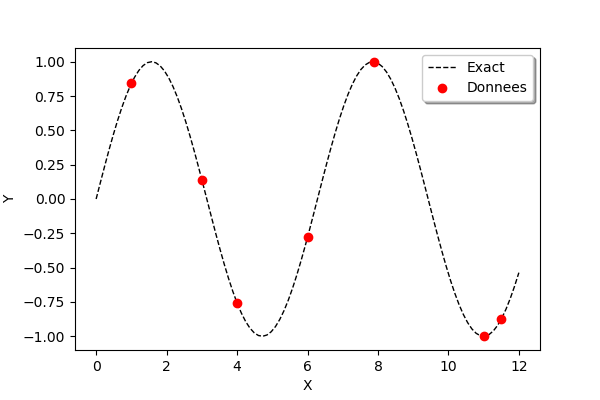

In [8]:
graph = ot.Graph()
graph.add(plot_data_test(x_test,y_test))
graph.add(plot_data_train(x_train,y_train))
graph.setAxes(True)
graph.setXTitle("X")
graph.setYTitle("Y")
graph.setLegendPosition("topright")
graph

Pour définir la tendance, nous utilisons la classe `ConstantBasisFactory`. La classe `MaternModel` permet de créer un modèle de covariance de Matern, associé au paramètre $\nu=3/2$.

In [9]:
dimension = 1
basis = ot.ConstantBasisFactory(dimension).build()
covarianceModel = ot.MaternModel([1.]*dimension, 2.5)

In [10]:
algo = ot.KrigingAlgorithm(x_train, y_train, covarianceModel, basis)
algo.run()
result = algo.getResult()
print(result)

KrigingResult(covariance models=MaternModel(scale=[0.330573], amplitude=[0.835621], nu=2.5), covariance coefficients=0 : [  1.02345  ]
1 : [  1.2246   ]
2 : [ -1.92421  ]
3 : [ -0.535011 ]
4 : [  1.76345  ]
5 : [ -1.92489  ]
6 : [  0.372625 ], basis=[Basis( [class=LinearEvaluation name=Unnamed center=[0] constant=[1] linear=[[ 0 ]]] )], trend coefficients=[[0.0140716]])


On observe que les paramètres d'échelle `scale` et d'amplitude on été optimisés par la méthode `run`. Puis, on récupère le métamodèle avec la méthode `getMetaModel` et on évalue la valeur du métamodèle sur la base de test.

In [11]:
krigeageMM = result.getMetaModel()
y_test_MM = krigeageMM(x_test)

Dans le but de comparer la valeur du méta-modèle avec la valeur du modèle sur la base de test, on réalise le graphique suivant. 

In [12]:
def plot_data_kriging(x_test,y_test_MM):
    '''Plots (x_test,y_test_MM) from the metamodel as a Curve, in blue'''
    graphK = ot.Curve(x_test,y_test_MM)
    graphK.setColor("blue")
    graphK.setLegend("Krigeage")
    return graphK

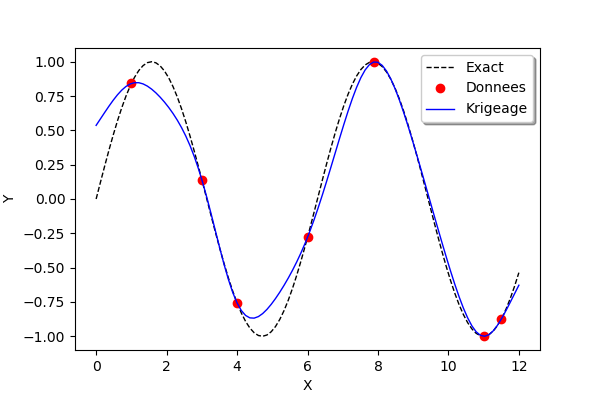

In [13]:
graph = ot.Graph()
graph.add(plot_data_test(x_test,y_test))
graph.add(plot_data_train(x_train,y_train))
graph.add(plot_data_kriging(x_test,y_test_MM))
graph.setAxes(True)
graph.setXTitle("X")
graph.setYTitle("Y")
graph.setLegendPosition("topright")
graph

On observe que, lorsque la fonction sinus a une forte courbure entre deux points d'apprentissage assez espacés, alors le métamodèle de krigeage n'est pas très proche de la fonction g. 

## Simuler des nouvelles trajectoires

TODO : avec 70 points dans la grille, on obtient :

    RuntimeError: InternalException : Error: the matrix is not definite positive.
    
Que faire dans ce cas ?

In [14]:
n_test = 60
step = (xmax-xmin)/(n_test-1)
myRegularGrid = ot.RegularGrid(xmin, step, n_test)
process = ot.ConditionedGaussianProcess(result, myRegularGrid)

In [15]:
trajectories = process.getSample(10)

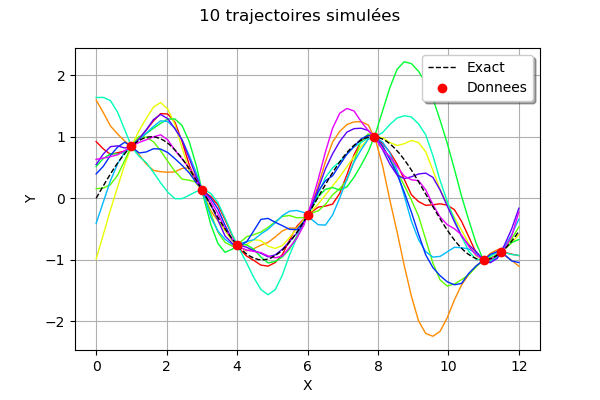

In [16]:
graph = trajectories.drawMarginal(0)
graph.add(plot_data_test(x_test,y_test))
graph.add(plot_data_train(x_train,y_train))
graph.setAxes(True)
graph.setXTitle("X")
graph.setYTitle("Y")
graph.setLegendPosition("topright")
graph.setTitle("10 trajectoires simulées")
graph